In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l
import random
import numpy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

npx.set_np()

In [2]:
## 数据文件的位置！！
DXX=pd.read_table(r"E:\NN\Data\2Dam\2Dam_XX.txt", sep='\s+', header=None)
DYY=pd.read_table(r"E:\NN\Data\2Dam\2Dam_YY.txt", sep='\s+', header=None)

In [3]:
NXX=np.array(DXX.values, dtype=np.float32, ctx=npx.gpu()).reshape(20000,5,1,154)
YY=DYY

In [4]:
n_train = 16000
train_features = NXX[:n_train,:,:,:]
test_features = NXX[n_train:,:,:,:]
train_labels = np.array(YY[:n_train].values*10, dtype=np.float32, ctx=npx.gpu())
test_labels = np.array(YY[n_train:].values*10, dtype=np.float32, ctx=npx.gpu())

In [5]:
batch_size=128
train_iter = d2l.load_array((train_features, train_labels), batch_size)
test_iter = d2l.load_array((test_features, test_labels), batch_size)

In [6]:
def MSE(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += ((net(X)-y)**2).sum()
        n += y.size
    return acc_sum / n

In [8]:
net = nn.Sequential()
net.add(nn.BatchNorm(),
        nn.Conv2D(channels=5, kernel_size=5, padding=2, activation='relu'),
        nn.Dense(308, activation='relu'),
        nn.Dense(154))
net.initialize(init.Normal(sigma=0.01), ctx=npx.gpu())
# net.load_parameters("2Dam_8", ctx=npx.gpu()) ## 这是可以直接调用训练好的参数！！需要注释前一行对参数的初始化
loss = gluon.loss.L2Loss()

In [9]:
train_ls, test_ls = [], []

In [10]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.0001,})

In [12]:
old_epochs=1
new_epochs=9

for epoch in range(new_epochs):
    for X, y in train_iter:
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(batch_size)
    train_ls.append(MSE(train_iter, net))
    test_ls.append(MSE(test_iter, net))
    print('epoch %d, train MSE %.6f, test MSE %.6f' % (old_epochs+epoch+1, train_ls[-1], test_ls[-1]))

epoch 2, train MSE 7.870446, test MSE 8.076224
epoch 3, train MSE 7.834415, test MSE 8.044726
epoch 4, train MSE 8.252594, test MSE 8.498034
epoch 5, train MSE 8.071236, test MSE 8.268981
epoch 6, train MSE 7.723184, test MSE 7.938908
epoch 7, train MSE 7.678327, test MSE 7.888087
epoch 8, train MSE 8.347885, test MSE 8.530684
epoch 9, train MSE 10.656083, test MSE 10.962817
epoch 10, train MSE 7.856472, test MSE 8.094130


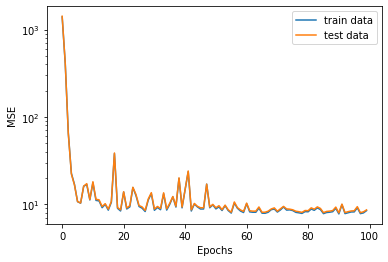

In [16]:
plt.plot(np.arange(old_epochs+new_epochs),train_ls,label='train data')
plt.plot(np.arange(old_epochs+new_epochs),test_ls,label='test data')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()

In [50]:
# net.save_parameters("2Dam_8")  ## 这是可以保存训练好的参数！！

In [52]:
def plots(net,ax,iindex=0):
    if iindex==0:
        ii=random.randint(n_train,DXX.shape[0])
    else:
        ii=iindex
    xd=DXX.iloc[ii,0:154].values
    yd=DXX.iloc[ii,154:308].values
    px=NXX[ii,:,:,:]
    py=YY.iloc[ii].values
    
    nxx=px.reshape(1,5,1,154)
    nyy=net(nxx).reshape(154,)
    
    zd=py*10
    zn=nyy.asnumpy()

    ax.scatter3D(xd,yd,zd, color='r',label='FEM' )
    ax.scatter3D(xd,yd,zn, color='b',label='NET' )
    ax.legend()

def plotopo(net,fig,style=1,iindex=0):
    if iindex==0:
        ii=random.randint(n_train,DXX.shape[0])
    else:
        ii=iindex
    xd=DXX.iloc[ii,0:154].values
    yd=DXX.iloc[ii,154:308].values
    xB=xd[75]
    yD=yd[3]
    triang = mtri.Triangulation(xd, yd)
    xmid = xd[triang.triangles].mean(axis=1)
    ymid = yd[triang.triangles].mean(axis=1)
    mask = numpy.where(((0<xmid)&(xmid<10)&(ymid<0)&(ymid>-1))|((0<xmid)&(xmid<xB)&(ymid<0)&(ymid>yD)), 1, 0)
    triang.set_mask(mask)
    
    px=NXX[ii,:,:,:]
    py=YY.loc[ii].values
    
    nxx=px.reshape(1,5,1,154)
    nyy=net(nxx).reshape(154,)
    
    zd=py*10
    zn=nyy.asnumpy()
    
    vmin=min(numpy.min(zd),numpy.min(zn))
    vmax=max(numpy.max(zd),numpy.max(zn))
    norm=colors.Normalize(vmin=0,vmax=vmax)
    
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_aspect(1)
    if style==1:
        im=ax1.tripcolor(triang, zd, cmap="jet", shading='gouraud')
    elif style==2:
        im=ax1.tricontourf(triang, zd,12, cmap="jet",norm=norm)
    # divider = make_axes_locatable(ax1)
    # cax = divider.append_axes("right", size="6%", pad=0.15)
    # cbar = plt.colorbar(im, cax=cax)
    # cbar.set_label('$u_y$',size=10)
    # cbar.ax.tick_params(labelsize=10)
    ax1.set_title('FEM')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_aspect(1)
    if style==1:
        im=ax2.tripcolor(triang, zn, cmap="jet", shading='gouraud')
    elif style==2:
        im=ax2.tricontourf(triang, zn,12, cmap="jet",norm=norm)
    
    fig.subplots_adjust(right=0.9)
    position = fig.add_axes([0.92, 0.12, 0.015, 0.76])
    # cbar = plt.colorbar(im, cax=cax)
    # cbar.set_label('$u_y$',size=10)
    # cbar.ax.tick_params(labelsize=10)
    cb=fig.colorbar(im, cax=position, ax=[ax1,ax2],norm=norm, cmap="jet",)
    cb.ax.tick_params(direction='in')
    ax2.set_title('NET')


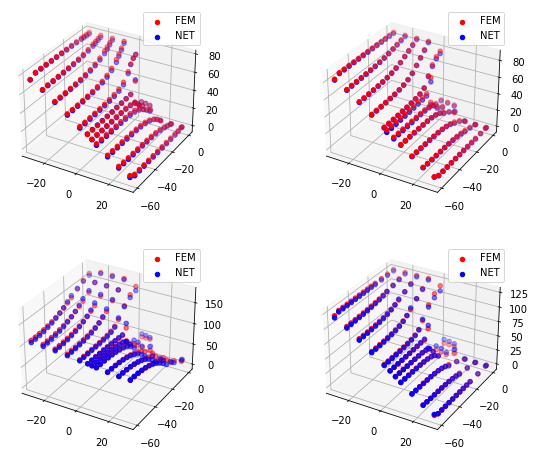

In [53]:
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(2, 2, 1, projection='3d');plots(net,ax)
ax = fig.add_subplot(2, 2, 2, projection='3d');plots(net,ax)
ax = fig.add_subplot(2, 2, 3, projection='3d');plots(net,ax)
ax = fig.add_subplot(2, 2, 4, projection='3d');plots(net,ax)

In [ ]:
for i in range(3):
    fig=plt.figure(figsize=(10,2));plotopo(net,fig,2)

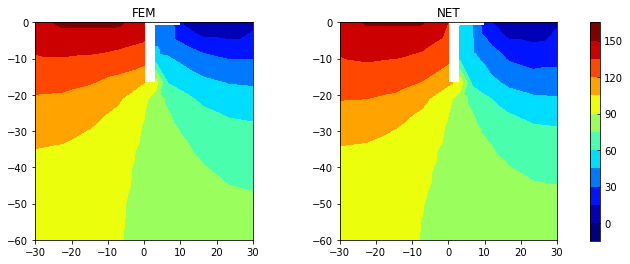

In [70]:
fig=plt.figure(figsize=(10,4));plotopo(net,fig,2)

In [ ]:
sMAPEerror=[]
for i in range(16000,20000):
    px=NXX[i,:,:,:]
    py=YY.iloc[i].values*10

    nxx=px.reshape(1,5,1,154)
    nyy=net(nxx).reshape(154,)

    ny=nyy.asnumpy()
    tmp=(abs(py-ny)/(abs(py)+abs(ny))).sum()
    tmp=tmp/py.size
    sMAPEerror.append(tmp)
print('Maxerror:', max(sMAPEerror))
print('Maxindex:', 16000+sMAPEerror.index(max(sMAPEerror)))

In [ ]:
sum(sMAPEerror)/4000